# Prevendo uma Campanha de Marketing com Machine Learning
> Usando Python e Sklearn

- toc: true 
- badges: true
- comments: true
- categories: [sklearn, python, machine learning]
- image: images/chart-preview.png

A Ciência de Dados tem um papel importante no processo de tomada de decisão de uma empresa. A alta disponibilidade de dados e a utilização de técnicas preditivas permitem às empresas otimizar seus custos com uma campanha ao focar nos clientes com maior potencial de rentabilidade.

Neste artigo mostro um exemplo disso na área de Marketing, utilizando um conjunto de dados obtida a partir de uma campanha de marketing de um banco português. A campanha tinha um objetivo de buscar clientes que fizessem depósitos a prazo, um tipo de produto bancário onde a instituição guarda os recursos dos clientes por um prazo determinado em troca de um pagamento de juros.

# A Base de Dados

A base tem 21 atributos, sendo 20 variáveis preditoras que são divididas em quatro tipos:

1. Dados do cliente: age, job, marital, education, default, housing, loan;
2. Relacionados ao último contato na atual campanha: contact, month, day_of_week, duration;
3. Contexto social e econômico: emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed;
4. Outros: campaign, pdays, previous, poutcome.

E uma variável resposta, chamada de y, que tem a categoria "yes" caso o cliente tenha assinado o depósito a prazo e "no" caso contrário. A descrição completa de todas as variáveis pode ser encontrada na página da [base](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing).

O objetivo então é utilizar as variáveis para prever quais clientes fizeram o depósito.

# Preparando os Dados

Primeiro vamos carregar os pacotes necessários para a análise.

In [2]:
# collapse-hide
import warnings
warnings.filterwarnings("ignore")

# Manipulação e Visualização de Dados
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Pré-Processamento
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Métricas e Seleção de Modelos
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

## Leitura e Divisão dos Dados

O conjunto de dados será lido a partir do pandas.

In [3]:
bank = pd.read_csv("../data/bank-additional-full.csv", sep=";")

Vamos dar uma olhada nas primeiras linhas do conjunto de treinamento e obter algumas informações sobre os tipos das colunas.

In [4]:
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

A princípio já se percebe que nenhuma das colunas tem valores NA e 10 dos 21 atributos são valores categóricos, incluindo a label y. Será necessário, portanto, buscar maneiras de codificar essas variáveis.

## Exploração dos Dados

Antes de explorar os dados é importante já dividi-los em conjuntos de treinamento e de teste. O sklearn já facilita esse trabalho.

In [6]:
bank_X = bank.drop("y", axis=1)
bank_y = bank[["y"]]

In [7]:
bank_X_tr, bank_X_tt, bank_y_tr, bank_y_tt = train_test_split(bank_X, bank_y, test_size=.3, random_state=42)

In [8]:
sns.set_theme(style="darkgrid", context="notebook")

### Label

In [9]:
bank_y_tr["y"].value_counts() / len(bank_y_tr)

no     0.887239
yes    0.112761
Name: y, dtype: float64

Os clientes que fizeram o depósito a prazo compoem cerca de 11% do conjunto de dados.

### Features Numéricas

In [10]:
bank_X_tr.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000
mean,40.011203,257.875134,2.575769,963.215844,0.172592,0.083202,93.577264,-40.515091,3.621599,5167.011880
std,10.450128,260.212911,2.752303,185.077567,0.494338,1.570978,0.579694,4.634864,1.735202,72.542598
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,318.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,4918.000000,43.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Pelas estatísticas descritivas, é possível perceber que algumas das variáveis podem ter outliers, tais como `age`, `duration`, `campaign` e `previous`. Nessas variáveis, os valores tendem a estar concentrados com valores de máximos e mínimos discrepantes em relação à média ou percentis das variáveis.

A variável `pdays` também indicaria a existencia de outliers, mas isso se deve somente pela forma como a variável foi codificada, onde 999 significa que o cliente nunca foi contactado.

In [30]:
pd.concat([bank_y_tr, bank_X_tr], axis=1).groupby("y").mean()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,,
no,39.927013,220.848006,2.645231,984.756919,0.132643,0.251427,93.605261,-40.601009,3.812835,5176.208432
yes,40.673639,549.217472,2.029222,793.723162,0.486927,-1.240449,93.356977,-39.839065,2.116890,5094.650200


Na análise bivariada entre as features numéricas e a label y podemos observar que: 

* `age` indica que os clientes que fizeram o depósito são mais velhos em aproximadamente um ano, na média;
* A duração da ligação, medida por `duration`, é maior entre os que fizeram o depósito;
* `campaign` indica que os clientes que fizeram o depósito receberam menos ligações em média durante a campanha, ao passo que `pdays` e `previous` indicam que o contato em campanhas anteriores parece ser, na média, um fator importante para a decisão de depósito;
* Entre os indicadores econômicos: decisões pelo depósito acontecerem, em média, durante períodos em que houve queda na taxa de emprego (`emp.var.rate`), de menores taxas de juros (`euribor3m`), de números menores de emprego (`nr.employed`) e de inflação (`cons.price.idx`) e maior índice de confiança do consumidor (`cons.conf.idx`).

#### Variáveis Categoricas

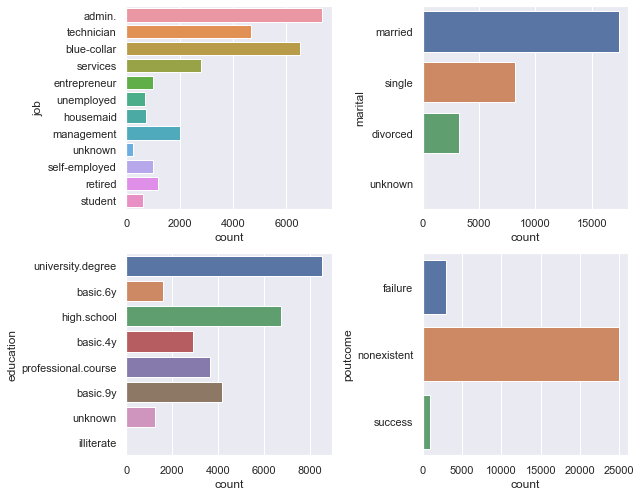

In [11]:
# collapse-hide
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))

sns.countplot(y="job", data=bank_X_tr, ax=axs[0, 0])
sns.countplot(y="marital", data=bank_X_tr, ax=axs[0, 1])
sns.countplot(y="education", data=bank_X_tr, ax=axs[1, 0])
sns.countplot(y="poutcome", data=bank_X_tr, ax=axs[1, 1])
plt.tight_layout()
plt.show()

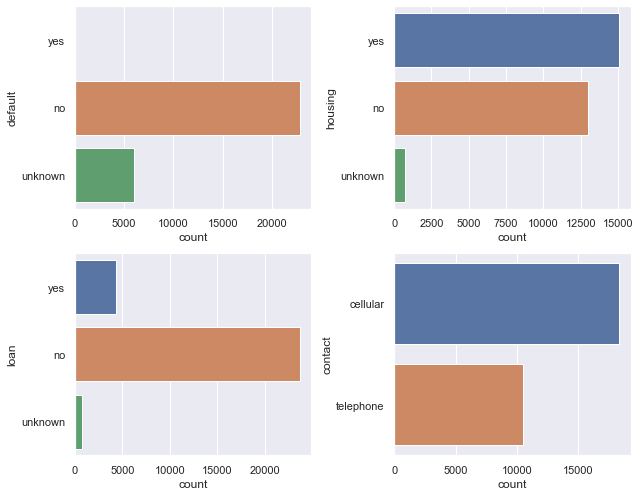

In [13]:
# collapse-hide
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))

sns.countplot(y="default", data=bank_X_tr, ax=axs[0, 0], order=["yes", "no", "unknown"])
sns.countplot(y="housing", data=bank_X_tr, ax=axs[0, 1], order=["yes", "no", "unknown"])
sns.countplot(y="loan", data=bank_X_tr, ax=axs[1, 0], order=["yes", "no", "unknown"])
sns.countplot(y="contact", data=bank_X_tr, ax=axs[1, 1])
plt.tight_layout()
plt.show()

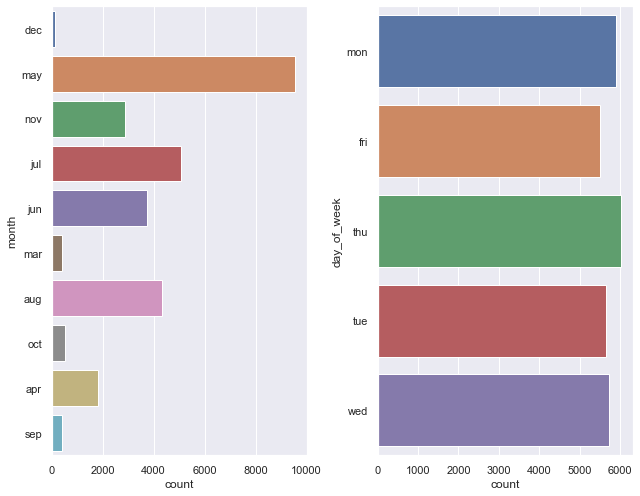

In [14]:
# collapse-hide
fig, axs = plt.subplots(ncols=2, figsize=(9, 7))

sns.countplot(y="month", data=bank_X_tr, ax=axs[0])
sns.countplot(y="day_of_week", data=bank_X_tr, ax=axs[1])
plt.tight_layout()
plt.show()

Conclusões sobre as variáveis categóricas:

* Podemos agregar as categorias em `education` com base se a categoria é de educação primária, secundária ou terciária;
* Em `default` só existem 3 indivíduos para a categoria "yes": vamos criar uma dummy que é 1 se a categoria é "no" e 0 caso contrário;
* Em `month` alguns meses tem poucas observações e outros tem bastante. Vamos testar agregações em trimestres e bimestres para ter categorias mais representativas.

### Análise Bivariada

In [19]:
bank_tr = pd.concat([bank_X_tr, bank_y_tr], axis=1)

In [20]:
bank_X_tr.corr()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,-0.003741,0.008758,-0.036666,0.027094,-0.000595,0.003682,0.126321,0.010074,-0.018042
duration,-0.003741,1.000000,-0.072445,-0.052064,0.020699,-0.029512,0.006035,-0.008210,-0.035028,-0.047273
campaign,0.008758,-0.072445,1.000000,0.050604,-0.077222,0.154406,0.128875,-0.013231,0.138310,0.147386
pdays,-0.036666,-0.052064,0.050604,1.000000,-0.581918,0.267267,0.069794,-0.089671,0.294894,0.373829
previous,0.027094,0.020699,-0.077222,-0.581918,1.000000,-0.418479,-0.199327,-0.054665,-0.452338,-0.498962
emp.var.rate,-0.000595,-0.029512,0.154406,0.267267,-0.418479,1.000000,0.772732,0.191490,0.972088,0.906417
cons.price.idx,0.003682,0.006035,0.128875,0.069794,-0.199327,0.772732,1.000000,0.052215,0.684425,0.517057
cons.conf.idx,0.126321,-0.008210,-0.013231,-0.089671,-0.054665,0.191490,0.052215,1.000000,0.273833,0.098496
euribor3m,0.010074,-0.035028,0.138310,0.294894,-0.452338,0.972088,0.684425,0.273833,1.000000,0.945113
nr.employed,-0.018042,-0.047273,0.147386,0.373829,-0.498962,0.906417,0.517057,0.098496,0.945113,1.000000


Correlações: tira nr.employed

#### Variáveis Numéricas

#### Variáveis Categóricas

Vamos tentar plotar duas coisas para cada variável categorica: o numéro de clientes que optaram pelo investimento vs o número de clientes que não optaram pelo investimento, e a porcentagem de clientes em cada categoria que optaram pelo investimento. Para isso, será criada uma função simples para aplicar em cada categoria

In [22]:
def plot_category(df, col):
    df_ = df.copy()
    tab = df_.groupby([col, "y"]).agg(n=("y", lambda x: x.value_counts())).reset_index()
    tab["%"] = tab["n"] / tab.groupby(col)["n"].transform("sum")
    
    fig, axes = plt.subplots(ncols=2, figsize=(9, 7), sharey=True)
    sns.barplot(x="n", y=col, hue="y", data=tab, ax=axes[0])
    sns.barplot(x="%", y=col, data=tab.query("y == 'yes'"), color="#cc8963", ax=axes[1])
    axes[1].set_xlabel("% of 'yes'")
    plt.tight_layout()
    plt.show()

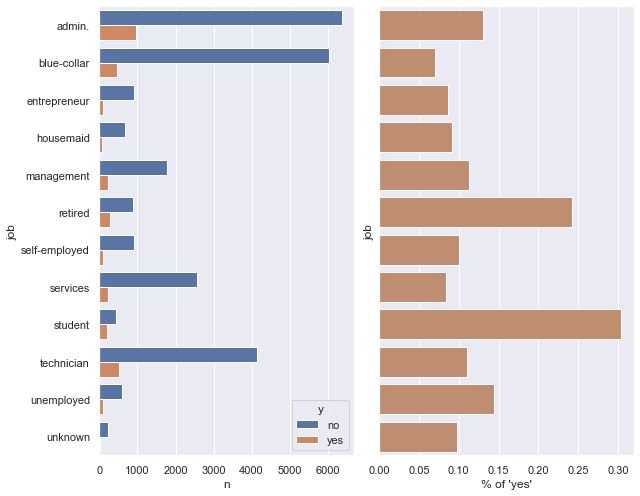

In [23]:
plot_category(bank_tr, "job")

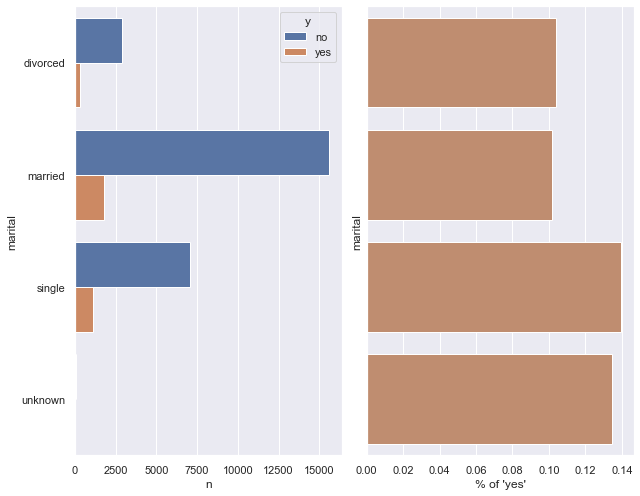

In [24]:
plot_category(bank_tr, "marital")

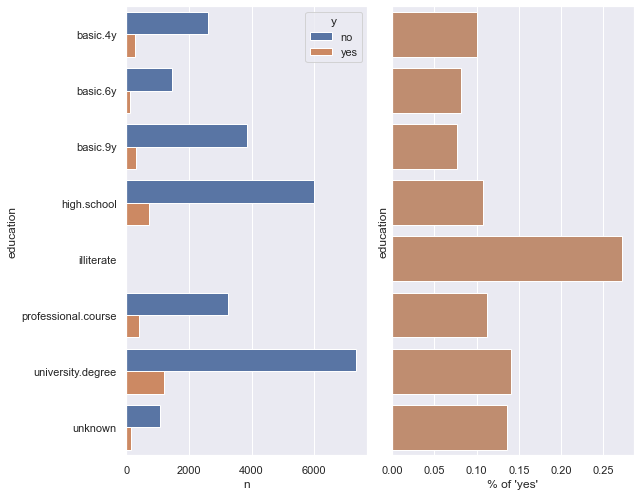

In [25]:
plot_category(bank_tr, "education")

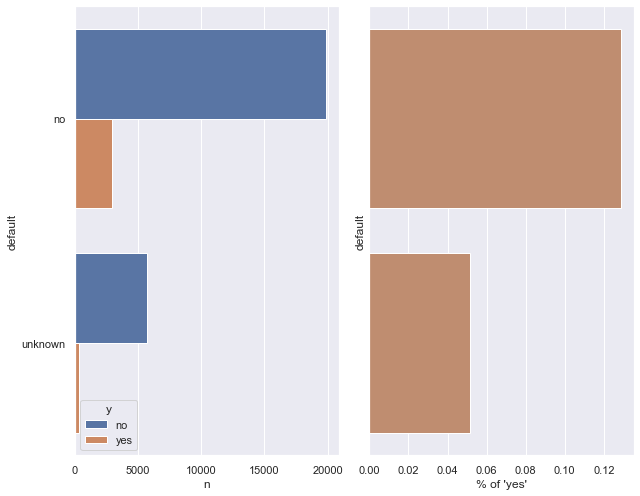

In [26]:
plot_category(bank_tr, "default")

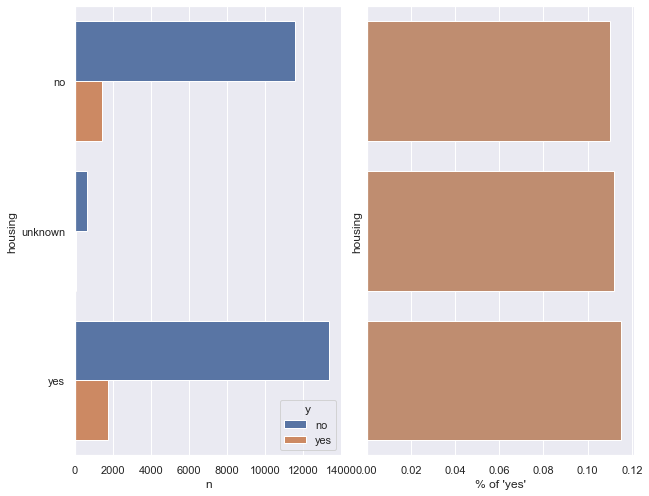

In [27]:
plot_category(bank_tr, "housing")

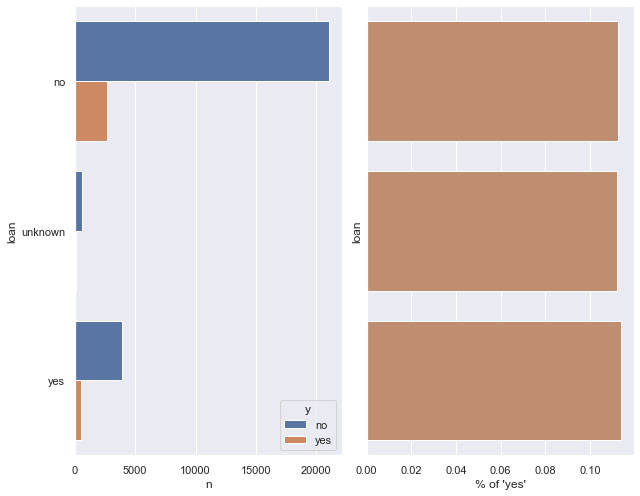

In [28]:
plot_category(bank_tr, "loan")

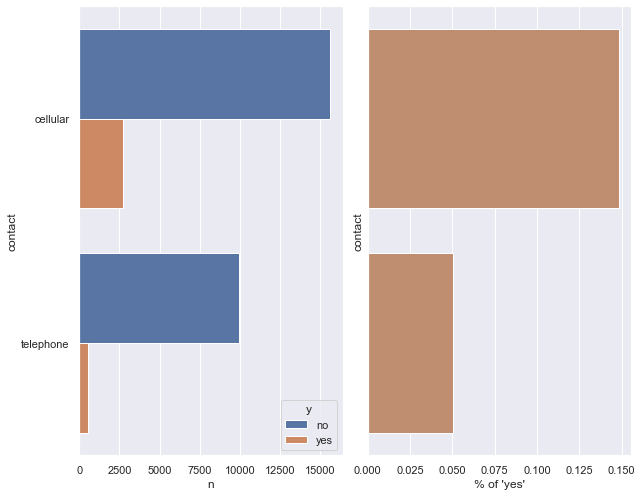

In [29]:
plot_category(bank_tr, "contact")

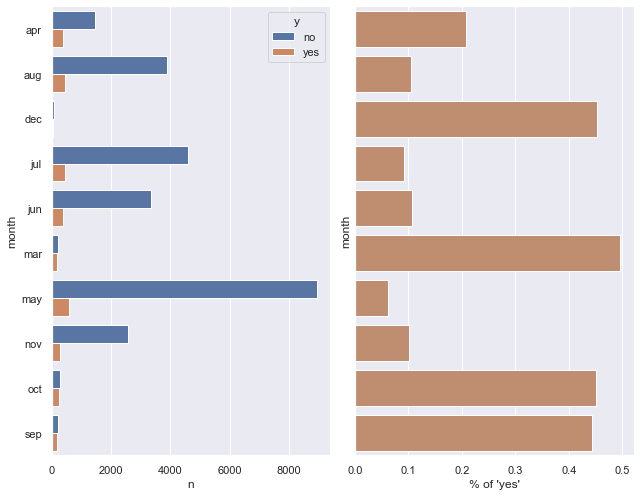

In [30]:
plot_category(bank_tr, "month")

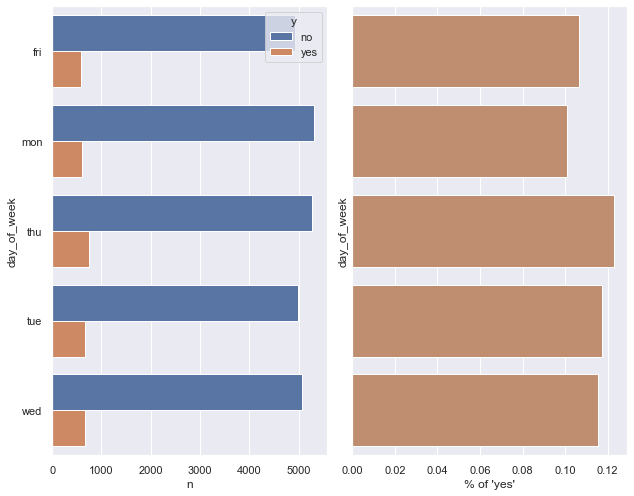

In [31]:
plot_category(bank_tr, "day_of_week")

Alguns destaques:

* Apesar de admin., blue-collar e technician serem a maioria dos clientes em `job`, retired e students são os clientes que proporcionalmente são os que mais optam pelo investimento;
* Em `education`, ilitarates são mais propensos, proporcionalmente, a fazer o investimento. Mas essa categoria é bastante pequena em números absolutos (a ponto de sumir da escala do gráfico), de forma que é dificil concluir que este seja um grupo importante para se focar;
* Em `month` os meses com maior proporção de clientes que optaram pelo investimento também são os meses com menor número de ligações, principalmente em dezembro. Portanto também é difícil que as ligações devem se focar nesses meses.

## Preparando a Base

Com a exploração dos dados, tiramos algumas modificações para algumas variáveis:

* Criar categorias para `age`, `campaign`, `pdays`, `previous`
* Agregar categorias em `education`;
* Em `default` criar uma dummy só para "no";
* Agregações trimestrais ou bimestrais em `month`.

Para facilitar todas as transformações, vamos criar pipelines no sklearn com o auxílio de transformadores personalizados.

In [69]:
def _age_cat(x):
    if x <= 31:
        return 1
    elif x > 31 and x <= 35:
        return 2
    elif x > 35 and x <= 41:
        return 3
    elif x > 41 and x <= 49:
        return 4
    elif x > 49:
        return 5
    
def _campaign_cat(x):
    if x <= 1:
        return 1
    elif x > 1 and x <= 3:
        return 2
    elif x > 3 and x <= 5:
        return 3
    elif x > 5:
        return 4
    
def _pdays_cat(x):
    if x == 999:
        return 1
    elif x <= 5:
        return 2
    elif x > 5 and x <= 10:
        return 3
    elif x > 10:
        return 4
    
def _previous_cat(x):
    if x <= 0:
        return 1
    elif x > 0 and x <= 2:
        return 2
    elif x > 2:
        return 3
    
def _educ_agg(x):
    if "basic" in x:
        return 2
    elif x == "high.school":
        return 3
    elif x in ["professional.course", "university.degree"]:
        return 4
    else:
        return 1
    
def _month_agg(x):
    if x == "mar":
        return 1
    elif x in ["apr", "may", "jun"]:
        return 2
    elif x in ["jul", "aug", "sep"]:
        return 3
    elif x in ["oct", "nov", "dec"]:
        return 4

In [70]:
class CreateNumCategories(BaseEstimator, TransformerMixin):
    def __init__(self, age_cat=True, campaign_cat=True, pdays_cat=True, previous_cat=True):
        self.age_cat = age_cat
        self.campaign_cat = campaign_cat
        self.pdays_cat = pdays_cat
        self.previous_cat = previous_cat
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_prep = X.copy()
        if self.age_cat:
            X_prep["age"] = X_prep["age"].apply(_age_cat)
        if self.campaign_cat:
            X_prep["campaign"] = X_prep["campaign"].apply(_campaign_cat)
        if self.pdays_cat:
            X_prep["pdays"] = X_prep["pdays"].apply(_pdays_cat)
        if self.previous_cat:
            X_prep["previous"] = X_prep["previous"].apply(_previous_cat)
        return X_prep
    
class AggCatVars(BaseEstimator, TransformerMixin):
    def __init__(self, educ_agg=True, month_agg = True):
        self.educ_agg = educ_agg
        self.month_agg = month_agg
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_prep = X.copy()
        if self.educ_agg:
            X_prep["education"] = X_prep["education"].apply(_educ_agg)
        if self.month_agg:
            X_prep["month"] = X_prep["month"].apply(_month_agg)
        return X_prep
    
class CustomOneHot(BaseEstimator, TransformerMixin):
    def __init__(self, col, onecat):
        self.col = col
        self.onecat = onecat
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_prep = X.copy()
        X_prep[self.col] = X_prep[self.col].apply(lambda x: 1 if x == self.onecat else 0)
        return X_prep

In [71]:
marital_order = ['unknown', 'single', 'married', 'divorced']
day_of_week_order = ["mon", "tue", "wed", "thu", "fri"]

In [72]:
num_to_cat = ["age", "campaign", "pdays", "previous"]
cat_agg = ["education", "month"]
ord_vars = ["marital", "day_of_week"]
oh_vars = [col for col in bank_X_tr.select_dtypes(include="object").columns if col not in num_to_cat + cat_agg + ord_vars]
others_num_vars = [col for col in bank_X_tr.select_dtypes(exclude="object").columns if col not in num_to_cat + ["duration"]]

pre_proc = ColumnTransformer([
    ("create_cat_from_num", CreateNumCategories(), num_to_cat),
    ("categories_agg", AggCatVars(), cat_agg),
    ("ord_vars", OrdinalEncoder(categories=[marital_order, day_of_week_order]), ["marital", "day_of_week"]),
    ("oh_vars", OneHotEncoder(), oh_vars),
    ("std_scaler", StandardScaler(), others_num_vars)
])

lb_bin = LabelBinarizer()

In [73]:
bank_X_tr_pp = pre_proc.fit_transform(bank_X_tr)
bank_X_tt_pp = pre_proc.transform(bank_X_tt)
bank_y_tr_pp = lb_bin.fit_transform(bank_y_tr)
bank_y_tt_pp = lb_bin.transform(bank_y_tt)

In [74]:
oh_vars

['job', 'default', 'housing', 'loan', 'contact', 'poutcome']

In [75]:
one_hot_vars = pre_proc.named_transformers_["oh_vars"].get_feature_names_out()

col_names = num_to_cat + cat_agg + ["marital", "day_of_week"] + one_hot_vars.tolist() + others_num_vars

In [76]:
pd.DataFrame(data=bank_X_tr_pp, columns=col_names)

,age,campaign,pdays,previous,education,month,marital,day_of_week,job_admin.,job_blue-collar,...,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,1.0,2.0,1.0,2.0,4.0,4.0,2.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,-1.962634,-1.490923,1.621455,-1.678565,-1.978346
1,1.0,3.0,1.0,1.0,4.0,2.0,1.0,4.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,-1.198766,-1.180409,-1.226575,-1.366780,-0.936182
2,4.0,2.0,1.0,1.0,2.0,2.0,2.0,3.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.647250,0.718902,0.887871,0.713705,0.330682
3,2.0,1.0,1.0,2.0,4.0,2.0,2.0,3.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,-1.198766,-1.180409,-1.226575,-1.322404,-0.936182
4,2.0,4.0,1.0,1.0,3.0,2.0,1.0,4.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,-1.198766,-1.180409,-1.226575,-1.366780,-0.936182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28826,5.0,2.0,1.0,1.0,4.0,2.0,2.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.647250,0.718902,0.887871,0.711976,0.330682
28827,3.0,1.0,1.0,1.0,4.0,2.0,2.0,3.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.838217,1.531413,-0.277232,0.771912,0.842115
28828,2.0,1.0,2.0,2.0,3.0,4.0,2.0,3.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,-2.217257,-1.977395,2.937589,-1.652631,-2.061058
28829,3.0,2.0,1.0,1.0,4.0,2.0,2.0,2.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.647250,0.718902,0.887871,0.711400,0.330682


## Modelos

Dado a natureza do problema, uma questão é qual métrica utilizar para avaliar os modelos. Já vimos que quase 90% da variável target é da classe negativa, ou sejá, 90% dos individuos no banco não fizeram o investimento. Dado esse nível de imbalanço nos dados, simplesmente utilizar acurácia pode ser problemático (um modelo que sempre prevê "não" como resultado da campanha vai ter acurácia de mais ou menos 90%).

Duas métricas importantes são a Precision e Recall. O primeiro dá a taxa de predições positivas que são verdadeiras (diminui a taxa de falsos positivos), e o segundo é a taxa de indivíduos da classe verdadeira que tiveram predição positiva (diminui a taxa de falsos negativos). O ideal é ter valores altos de Precision e Recall, mas normalmente isso não é possível. Há um trade-off entre as duas taxas e geralmente aumentar a Precision diminui a Recall e vice-versa. O coisa a se pensar então é: qual métrica vai ser mais importante para o nosso problema?

Podemos pensar um pouco sobre custos e benefícios de cada ligação feita para cada cliente. Vamos supor que a decisão de ligar ou não é feita com base na predição positiva feita pelo nosso modelo. 

Ligações incorrem em custos: ao fazer a ligação, o banco terá custos com telefonia, com o treinamento e os salários dos atendentes e etc. Se a ligação for feita para alguém que é pouco provável que fará o investimento, ela será uma ligação que só terá custos, sem nenhum retorno na forma da decisão do investimento para o banco. A métrica de Precision é essencial aqui: desejamos que a maior parte possível de nossas ligações (que, como supomos, foram definidas com base nas predições do modelo) seja para pessoas com chance real de comprar o produto financeiro, diminuindo os custos relativos aos benefícios. Ou seja, desejamos que as ligações sejam focadas ao máximo possível em clientes com alto valor.

Mas há também outra questão aqui. Uma Precision maior equivale a uma Recall menor, e aqui também é interessante uma boa métrica de Recall. Se o objetivo é maximizar os benefícios (em forma de lucros futuros), desejamos não só que a maioria de nossas ligações sejam para clientes de alto valor, desejamos também que nós não deixassemos "passar batido" clientes de alto valor.

No mundo real provavelmente o banco teria algumas estimativas de custos e receitas para cada ligação durante a campanha. Se o custo de uma ligação é baixoar as receitas esperadas com a decisão do cliente de comprar o produto compensar e muito o custo de uma ligação, pode ser interessante aceitar taxas menores de Precision (ou seja, aceitar que a maioria das ligações não seja para pessoas que fariam a compra) com taxas maiores de Recall (Ou seja, garantir que o máximo de clientes que fariam a compra seja contactado).

Seguirei essa suposição então e o modelo final será avaliado com base no Recall.

### Buscando alguns modelos promissores

A ideia aqui é somente testar alguns modelos comumente utilizados para classificação e pegar os 5 mais promissores, sem nenhum ajuste nos hiperparâmetros. Definirei que um modelo é promissor com base no seu ROC-AUC Score: A ideia é só escolher uns modelos que sejam sejam bons preditores da classe positiva (o que se traduz em maior score).

In [61]:
clfs = [
    LogisticRegression,
    GaussianNB,
    KNeighborsClassifier,
    LinearSVC,
    DecisionTreeClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier
]

In [62]:
clf_name = []
precision_tr = []
recall_tr = []
precision_cv = []
recall_cv = []
roc_auc_score_cv = []

for clf in clfs:
    m = clf()
    
    m_name = m.__class__.__name__
    
    clf_name.append(m_name)
    m.fit(bank_X_tr_pp, bank_y_tr_pp)
    tr_pred = m.predict(bank_X_tr_pp)
    precision_tr.append(precision_score(bank_y_tr_pp, tr_pred))
    recall_tr.append(recall_score(bank_y_tr_pp, tr_pred))
    
    cv_pre = cross_val_score(m, bank_X_tr_pp, bank_y_tr_pp, scoring="precision", cv=10)
    cv_rec = cross_val_score(m, bank_X_tr_pp, bank_y_tr_pp, scoring="recall", cv=10)
    cv_auc = cross_val_score(m, bank_X_tr_pp, bank_y_tr_pp, scoring="roc_auc", cv=10)
    precision_cv.append(np.mean(cv_pre))
    recall_cv.append(np.mean(cv_rec))    
    roc_auc_score_cv.append(np.mean(cv_auc))
    print(m_name)

LogisticRegression
GaussianNB
KNeighborsClassifier
LinearSVC
DecisionTreeClassifier
RandomForestClassifier
GradientBoostingClassifier


In [63]:
models_df = pd.DataFrame({"name": clf_name, "precision_tr": precision_tr, "recall_tr": recall_tr, "precision_cv": precision_cv, "recall_cv": recall_cv, "roc_auc_score_cv": roc_auc_score_cv})

In [64]:
models_df.sort_values("roc_auc_score_cv", ascending=False)

,name,precision_tr,recall_tr,precision_cv,recall_cv,roc_auc_score_cv
6,GradientBoostingClassifier,0.709076,0.269148,0.669895,0.252540,0.802125
0,LogisticRegression,0.681329,0.214396,0.684482,0.212546,0.783351
3,LinearSVC,0.699408,0.181790,0.701484,0.181480,0.779494
5,RandomForestClassifier,0.983339,0.907721,0.522294,0.308516,0.769161
1,GaussianNB,0.241669,0.698247,0.240775,0.695166,0.757945
2,KNeighborsClassifier,0.730310,0.376500,0.545241,0.273444,0.724898
4,DecisionTreeClassifier,0.996238,0.896032,0.317808,0.330664,0.621888


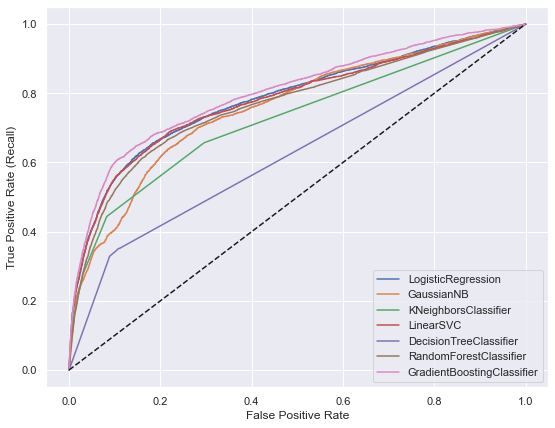

In [65]:
fig, ax = plt.subplots(figsize=(9, 7))

for clf in clfs:
    _clf = clf()
    _clf_name = _clf.__class__.__name__
    
    y_preds = cross_val_predict(_clf, bank_X_tr_pp, bank_y_tr_pp.ravel(), cv = 10, method = "predict_proba" if _clf_name != "LinearSVC" else "decision_function")
    
    fpr, tpr, thresholds = roc_curve(y_true=bank_y_tr_pp, y_score=y_preds[:, 1] if _clf_name != "LinearSVC" else y_preds)
    
    ax.plot(fpr, tpr, label=_clf_name)

ax.plot([0, 1], [0, 1], "k--")
ax.legend()
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate (Recall)")
plt.show()

Olhando somente o roc_auc_score feito por cross-validation, os modelos de GradientBoosting, AdaBoost e Logistic Regression parecem ser os três mais promissores. Vamos testar diferentes hiperparâmetros dos três modelos e verificar novamente o roc_auc_score dos melhores modelos entre os três mais promissores.

### GradientBoosting

In [78]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [79]:
grad_boost = GradientBoostingClassifier()

params = {
    "loss": ["log_loss", "exponential"],
    "n_estimators": [100, 200, 300],
    "subsample": uniform(loc=0, scale=1),
    "min_samples_split": uniform(loc=0, scale=1),
    "min_samples_leaf": uniform(loc=0, scale=1),
    "max_depth": np.arange(0, 11),
    "max_features": uniform(loc=0, scale=1),
}

gb_clf = RandomizedSearchCV(
    grad_boost, 
    params, 
    cv=10,
    
    random_state=42,
    n_jobs=-1,
    scoring="roc_auc",
    n_iter=100
)

In [80]:
gb_clf.fit(bank_X_tr_pp, bank_y_tr_pp)

RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'loss': ['log_loss', 'exponential'],
                                        'max_depth': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002CBA7E200A0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002CBA7E20BE0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002CBA76DD640>,
                                        'n_estimators': [100, 200, 300],
                                        'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002CBA76DD7F0>},
                   random_state=42, scoring='roc_auc')

In [67]:
print("ROC-AUC do Melhor Estimador:", gb_clf.best_score_)
gb_clf.best_estimator_

ROC-AUC do Melhor Estimador: 0.8027070883303489


GradientBoostingClassifier(loss='exponential', max_depth=8,
                           max_features=0.6635017691080558,
                           min_samples_leaf=0.005061583846218687,
                           min_samples_split=0.16080805141749865,
                           n_estimators=200, subsample=0.4856137535862266)

Uma melhora bem marginal comparado ao modelo com hiperparâmetros padrões

In [86]:
predicts_gb = cross_val_predict(gb_clf.best_estimator_, bank_X_tr_pp, bank_y_tr_pp.ravel(), cv = 10, method = "predict_proba")

In [94]:
precision_score(bank_y_tr_pp, predicts_gb[:, 1] >= 0.16)

0.4205768402927249

In [95]:
recall_score(bank_y_tr_pp, predicts_gb[:, 1] >= 0.16)

0.6010458320516764

## Testando no Conjunto de Teste

In [96]:
bank_predictions = gb_clf.best_estimator_.predict_proba(bank_X_tt_pp)[:, 1]

In [97]:
precision_score(bank_y_tt_pp, bank_predictions >= 0.16223956223837027)

0.4237644584647739

In [98]:
confusion_matrix(bank_y_tt_pp,  bank_predictions >= 0.16223956223837027)

array([[9872, 1096],
       [ 583,  806]], dtype=int64)

In [75]:
confusion_matrix(bank_y_tt_pp,  bank_predictions >= 0.16223956223837027)

array([[9893, 1075],
       [ 583,  806]], dtype=int64)

In [49]:
custo_total = 1101*2
receita_total = 806*5
receita_total - custo_total

1828

In [77]:
960/(960+429)

0.6911447084233261

In [102]:
feature_importances = pd.DataFrame(data=zip(col_names, gb_clf.best_estimator_.feature_importances_), columns=["feature", "importance"])
feature_importances.sort_values("importance", ascending=False).eval("importance = importance * 100")

,feature,importance
38,nr.employed,38.917025
37,euribor3m,19.235245
2,pdays,11.352106
36,cons.conf.idx,6.918561
33,poutcome_success,5.559827
35,cons.price.idx,2.598499
5,month,2.352509
34,emp.var.rate,1.875889
1,campaign,1.361313
7,day_of_week,1.358204
